In [1]:
import AssetManagerMachineLearning as aml
import numpy as np, pandas as pd, matplotlib.pyplot as plt

### Denoising and Detoning

Maecenko-Pastur pdf

In [2]:
N = 1000
T = 10000
x = np.random.normal(0, 1, size = (T, N))
cor = np.corrcoef(x, rowvar=0) # cor.shape = (1000,1000). If rowvar=1 - row represents a var, with observations in the columns.
eVal0 , eVec0 = aml.getPCA( cor )
pdf0 = aml.mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=N)
pdf1 = aml.fitKDE(np.diag(eVal0), bWidth=.005) #empirical pdf

<Axes: >

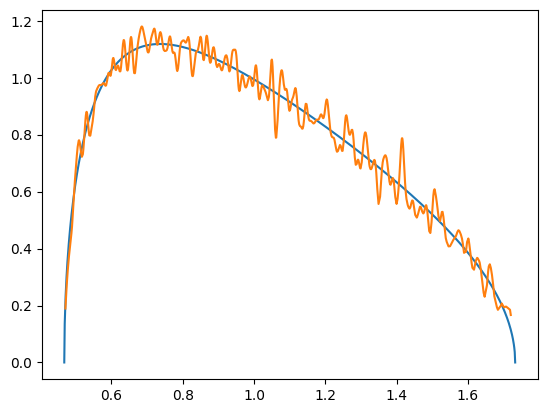

In [3]:
pdf0.plot()
pdf1.plot()

In [4]:
# code snippet 2.3 - random matrix with signal
alpha, nCols, nFact, q = .995, 1000, 100, 10
pdf0 = aml.mpPDF(1., q = x.shape[0]/float(x.shape[1]), pts = N)
cov = np.cov(np.random.normal(size = (nCols*q, nCols)), rowvar = 0) #size = (1000*10,1000)
cov = alpha * cov+(1 - alpha) * aml.getRndCov(nCols, nFact) # noise + signal
corr0 = aml.cov2corr(cov)
eVal01, eVec01 = aml.getPCA(corr0)
pdf2 = aml.fitKDE(np.diag(eVal01), bWidth=.15) #empirical pdf

<Axes: >

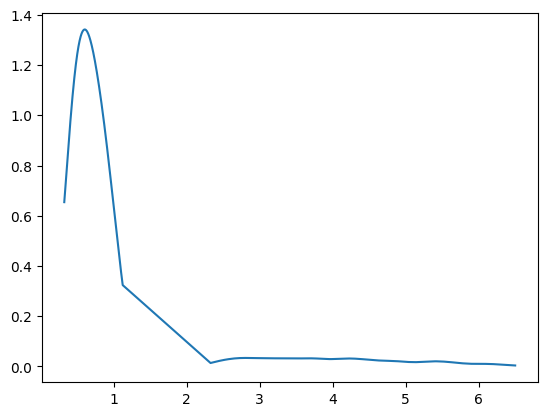

In [5]:
pdf2.plot()

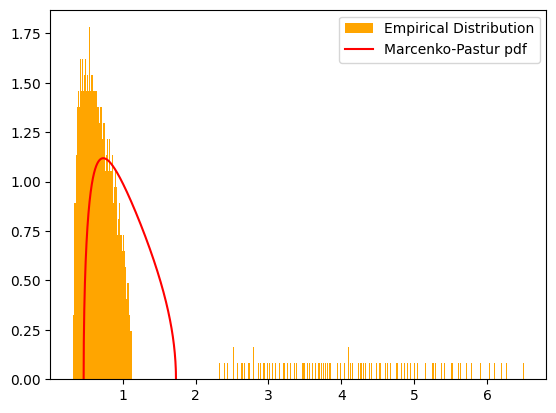

In [6]:
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.hist(np.diag(eVal01), density = True, bins = 500, label = "Empirical Distribution", color = 'orange') # Histogram the eigenvalues

plt.plot(pdf0.keys(), pdf0, color = 'red', label = "Marcenko-Pastur pdf")
#plt.plot(pdf1.keys(), pdf1, color='g', label = "Empirical:KDE")
#plt.plot(pdf2, color='b', label="Eigenvalues of random-matrix with signal")
plt.legend(loc="upper right")
plt.show()

In [7]:
eMax0, var0 = aml.findMaxEval(np.diag(eVal01), q, bWidth=.01)
nFacts0 = eVal01.shape[0]-np.diag(eVal01)[::-1].searchsorted(eMax0)

found errPDFs0.6756260854236916


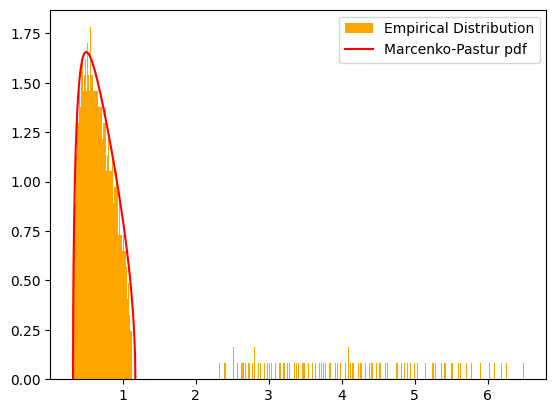

In [8]:
pdf0 = aml.mpPDF(var0, q=x.shape[0]/float(x.shape[1]), pts=N)
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.hist(np.diag(eVal01), color = 'orange', density = True, bins=500, label = "Empirical Distribution") # Histogram the eigenvalues

plt.plot(pdf0.keys(), pdf0, color='r', label="Marcenko-Pastur pdf")
#plt.plot(pdf1.keys(), pdf1, color='g', label="Empirical:KDE")
#plt.plot(pdf2, color='b', label="Eigenvalues of random-matrix with signal")
plt.legend(loc="upper right")
plt.show()

In [9]:
corr1 = aml.denoisedCorr(eVal01, eVec01, nFacts0)
eVal1, eVec1 = aml.getPCA(corr1)

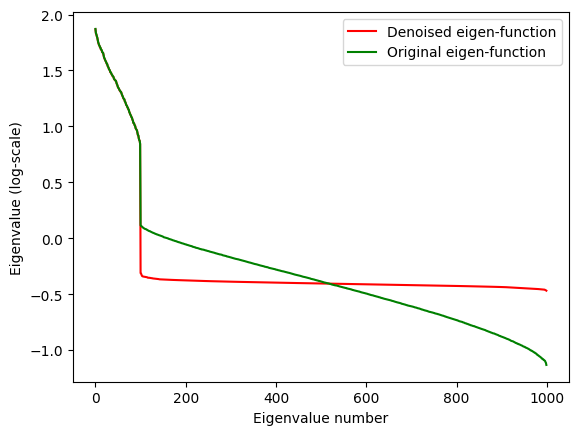

In [10]:
denoised_eigenvalue = np.diag(eVal1)
eigenvalue_prior = np.diag(eVal01)
plt.plot(range(0, len(denoised_eigenvalue)), np.log(denoised_eigenvalue), color='r', label="Denoised eigen-function")
plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), color='g', label="Original eigen-function")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc="upper right")
plt.show()

In [11]:
nBlocks, bSize, bCorr = 2, 2, .5
np.random.seed(0)
mu0, cov0 = aml.formTrueMatrix(nBlocks, bSize, bCorr)

In [12]:
nObs, nTrials, bWidth, shrink, minVarPortf = 5, 5, .01, False, True
w1 = pd.DataFrame(columns = range(cov0.shape[0]), index = range(nTrials), dtype=float)

In [13]:
w1_d = w1.copy(deep=True)
np.random.seed(0)
for i in range(nTrials):
    mu1, cov1 = aml.simCovMu(mu0, cov0, nObs, shrink = shrink)
    if minVarPortf: mu1 = None
    cov1_d = aml.deNoiseCov(cov1, nObs*1./cov1.shape[1], bWidth)
    w1.loc[i] = aml.optPort(cov1, mu1).flatten() # add column vector w as row in w1
    w1_d.loc[i] = aml.optPort(cov1_d, mu1).flatten() # np.sum(w1_d, axis=1) is vector of 1's. sum(np.sum(w1_d, axis=0)= nTrials
    # so minimum-variance-portfolio is 1./nTrials*(np.sum(w1_d, axis=0)) - but distribution not stationary

min_var_port = 1./nTrials*(np.sum(w1_d, axis=0))

found errPDFs0.99999
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Aug 30 01:02:10 AM: Your problem has 4 variables, 2 constraints, and 0 parameters.
(CVXPY) Aug 30 01:02:10 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 30 01:02:10 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 30 01:02:10 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 30 01:02:10 AM: Compiling problem (target solver=OSQP).
(CVXPY) Aug 30 01:02:10 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp

In [14]:
#code snippet 2.11
w0 = aml.optPort(cov0, None if minVarPortf else mu0) # w0 true percentage asset allocation
w0 = np.repeat(w0.T, w1.shape[0], axis=0)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Aug 30 01:02:10 AM: Your problem has 4 variables, 2 constraints, and 0 parameters.
(CVXPY) Aug 30 01:02:10 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 30 01:02:10 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 30 01:02:10 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 30 01:02:10 AM: Compiling problem (target solver=OSQP).
(CVXPY) Aug 30 01:02:10 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing 

In [15]:
rmsd = np.mean((w1-pd.DataFrame(w0.reshape(5,4))).values.flatten()**2)**.5     #RMSE not denoised
rmsd_d = np.mean((w1_d-pd.DataFrame(w0.reshape(5,4))).values.flatten()**2)**.5 #RMSE denoised
print("RMSE not denoised:"+str( rmsd))
print("RMSE denoised:"+str( rmsd_d))

RMSE not denoised:0.2651389560211777
RMSE denoised:0.1484375643157755


denoise된 공분산행렬의 RMSE가 더 낮게 나온다

#### Exercise 1
2.6절에 설명된 잡음 제거 방법을 파이썬으로 구현하라

In [16]:
corr_detoned_denoised = aml.detoned_corr(corr1, eVal1, eVec1)

eVal1_detoned, eVec1_detoned = aml.getPCA(corr_detoned_denoised)
detoned_denoised_eigenvalue = np.diag(eVal1_detoned)
denoised_eigenvalue = np.diag(eVal1)
eigenvalue_prior = np.diag(eVal01)

/var/folders/7g/v3wmln7x2mv8wqmn923x0qy40000gn/T/ipykernel_76743/669325748.py:1: RuntimeWarning: invalid value encountered in log
  plt.plot(range(0, len(detoned_denoised_eigenvalue)), np.log(detoned_denoised_eigenvalue), color='b', label="Detoned, denoised eigen-function")


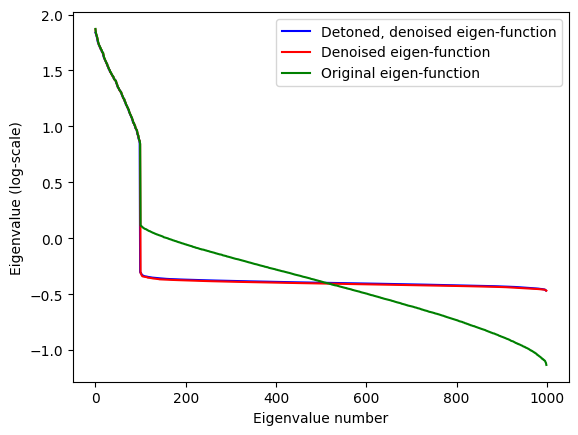

In [17]:
plt.plot(range(0, len(detoned_denoised_eigenvalue)), np.log(detoned_denoised_eigenvalue), color='b', label="Detoned, denoised eigen-function")
plt.plot(range(0, len(denoised_eigenvalue)), np.log(denoised_eigenvalue), color='r', label="Denoised eigen-function")
plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), color='g', label="Original eigen-function")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc="upper right")
plt.show()

#### Exercise 2
일련의 주식 수익률 행렬을 사용한다

In [18]:
import pandas_datareader as web
start_date = '2019-01-22'
end_date = '2023-06-15'

kodex_etf = '069500' # KODEX 200
kospi200_etf = '069660'  # kiwoom KOSEF KOSPI 200
kosdaq150_etf = '316670'  # kiwoom KOSDAQ 150
samsung_code = '005930'  # Samsung
lg_code = '066570'  # LG
posco_code = '005490'  # POSCO

kodex = web.DataReader(kodex_etf, 'naver', start = start_date, end = end_date).astype(float).Close
kospi = web.DataReader(kospi200_etf, 'naver', start = start_date, end = end_date).astype(float).Close
kosdaq = web.DataReader(kosdaq150_etf, 'naver', start = start_date, end = end_date).astype(float).Close
samsung = web.DataReader(samsung_code, 'naver', start = start_date, end = end_date).astype(float).Close
lg = web.DataReader(lg_code, 'naver', start = start_date, end = end_date).astype(float).Close
posco = web.DataReader(posco_code, 'naver', start = start_date, end = end_date).astype(float).Close

In [19]:
data = pd.concat([kodex, kospi, kosdaq, samsung, lg, posco], axis = 1)
data.columns = ['KODEX','KOSPI200','KOSDAQ150','Samsung','LG','Posco']
ret = np.log(data) - np.log(data.shift(1))
ret = ret.dropna()
ret

,KODEX,KOSPI200,KOSDAQ150,Samsung,LG,Posco
Date,,,,,,
2019-01-23,0.005788,0.004982,-0.004474,-0.003565,0.010794,-0.007519
2019-01-24,0.008205,0.008511,0.014955,0.024693,0.000000,-0.001889
2019-01-25,0.017996,0.018435,0.011246,0.038729,0.063867,0.013146
2019-01-28,-0.000582,-0.000310,0.007832,0.006682,-0.026241,0.003724
2019-01-29,0.004838,0.005020,-0.001735,0.009939,-0.004441,-0.001860
...,...,...,...,...,...,...
2023-06-09,0.013188,0.013186,0.014153,0.015396,-0.003954,0.015346
2023-06-12,-0.006485,-0.006789,0.003691,-0.013986,-0.004766,-0.006365
2023-06-13,0.004752,0.005204,0.019701,0.013986,-0.009600,-0.005122


**(a)** 공분산 행렬을 계산하라. 상관계수 행렬의 조건 수는 무엇인가?

In [20]:
covmat = ret.cov()
covmat

,KODEX,KOSPI200,KOSDAQ150,Samsung,LG,Posco
KODEX,0.000161,0.000161,0.000168,0.000172,0.000165,0.000151
KOSPI200,0.000161,0.000162,0.000168,0.000173,0.000165,0.000151
KOSDAQ150,0.000168,0.000168,0.000323,0.000150,0.000168,0.000141
Samsung,0.000172,0.000173,0.000150,0.000253,0.000153,0.000141
LG,0.000165,0.000165,0.000168,0.000153,0.000620,0.000156
Posco,0.000151,0.000151,0.000141,0.000141,0.000156,0.000443


In [21]:
codnum = np.linalg.cond(covmat)
codnum # 상관계수 행렬의 조건 수

3063.7472886440537

**(b)** 평균 10%와 표준편차 10%인 정규분포에서 100개의 대체 기대 수익률 벡터를 도출해서 Efficient Frontier 100개를 계산하라

calculating efficient frontier using optimization method::   0%|          | 0/30 [00:00<?, ?it/s]

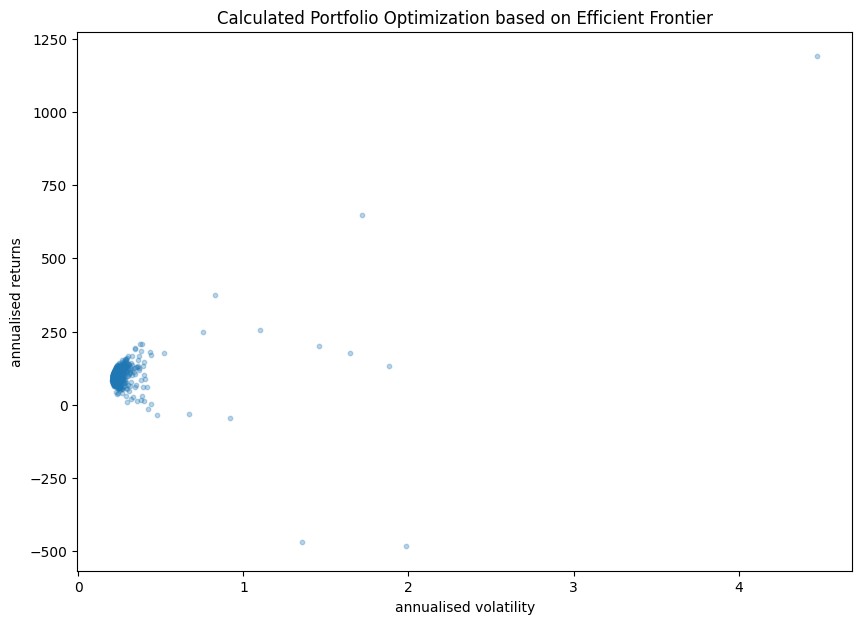

In [22]:
target_ret = ret.T # select 50 stocks to construct portfolio
target_cov = target_ret.cov()
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax,frontier_ret = aml.ef_with_random_portfolio_opt(target_ret, target_cov, 1000, ax = ax)

  0%|          | 0/100 [00:00<?, ?it/s]

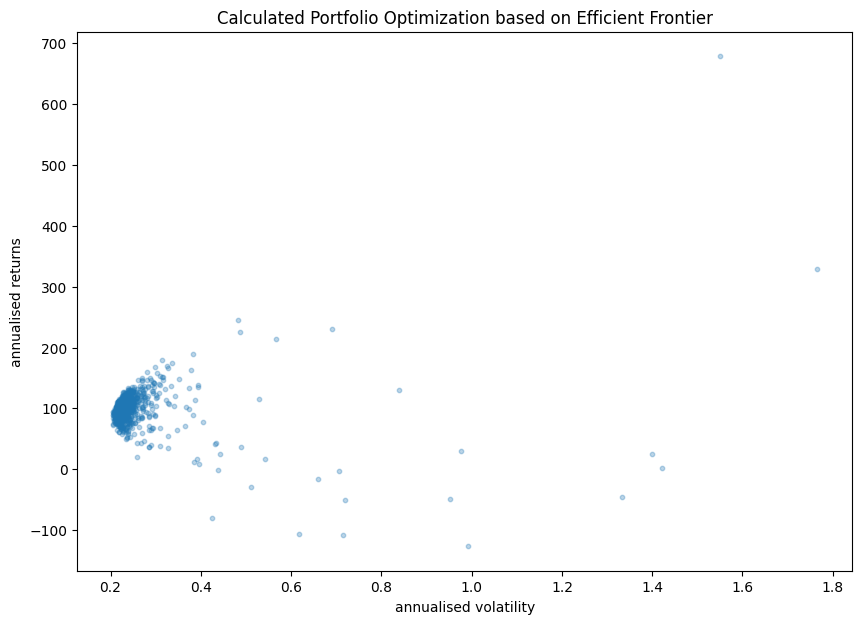

In [23]:
mean_frontier = aml.MC_ef_frontier(ret, covmat, itertimes = 100, random_seed = 42)

**(c)** 평균 효율적 경계에 대한 오차의 분산을 계산하라

In [24]:
aml.error_mean_ef_frontier(frontier_ret, np.array(mean_frontier))

262.05505880780015

#### Exercise 3
Exercise 2를 반복한다. 여기서 이번에는 공분산 행렬의 잡음을 제거한 후 100개의 Efficient Frontier를 계산하라

----------


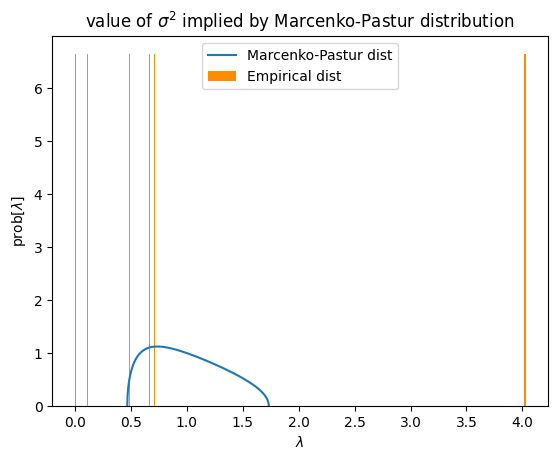

In [25]:
from scipy.optimize import minimize

corr3 = aml.cov2corr(covmat)
eVal3,eVec3 = aml.getPCA(corr3)
bWidth=0.01
out = minimize(lambda *x: aml.errPDFs(*x), 0.5, args = (np.diag(eVal3),q,bWidth), bounds = ((1E-5,1-1E-5),))
if out['success']:
    var=out['x'][0]
else:
    var=1
print('-'*10)
pdf0 = aml.mpPDF(var, q, pts = 1000) # Marcenko-Pastur dist
pdf3 = aml.fitKDE(np.diag(eVal3),bWidth=.01) # empirical pdf
ax = plt.figure().add_subplot(111)
ax.plot(pdf0, label= 'Marcenko-Pastur dist')
ax.bar(pdf3.index, pdf3.values, width = bWidth,label= 'Empirical dist', color = 'darkorange')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'prob[$\lambda$]')
ax.set_title(r'value of $\sigma^2$ implied by Marcenko-Pastur distribution')
ax.legend()

**(a)** 마르첸코 - 파스퇴르 분포에서 암시하는 $\sigma^2$의 값은 무엇인가?

In [26]:
print(pdf0.var())

0.08005208547161317


마르첸코-파스퇴르 분포는 정상적인 행렬의 고유값 분포를 설명하는 분포로서, 주로 차원이 큰 상황에서 관찰되는 특성이다. 이 분포는 고유값들의 분포를 특징짓는데, 이는 주어진 행렬의 성질과 연관된다. 마르첸코-파스퇴르 분포의 분산은 주어진 표본공분산 행렬의 고유값들이 얼마나 분산되어 있는지를 나타낸다. 분산이 작을수록 고유값들이 집중되어 있음을 의미하며, 분산이 클수록 고유값들이 넓게 분포되어 있음을 의미한다. 이 분산은 행렬의 차원, 데이터의 특성, 공분산 행렬의 구조 등에 영향을 받는다.

마르첸코-파스퇴르 분포의 분산을 분석하면, 데이터의 주성분 개수를 결정하거나, 포트폴리오의 다양성을 평가하는 데 도움을 줄 수 있다. 또한, 분산을 이용하여 고유값들의 중요도를 평가하고, 데이터의 차원 축소를 수행하는 등의 다양한 응용이 가능하다.

**(b)** 랜덤 성분과 관련된 고유값은 몇 개인가?

In [27]:
raneigen = aml.random_eigenvalues(covmat)
print(raneigen)

[3.59158694e-08 1.49932606e-08 4.39991255e-09 5.62189773e-10
 3.92219287e-25 4.85334467e-14]


6개이다

**(c)** 오차의 분산이 유의하게 더 높은가 아니면 더 낮은가? 그 이유는 무엇인가?

  0%|          | 0/100 [00:00<?, ?it/s]

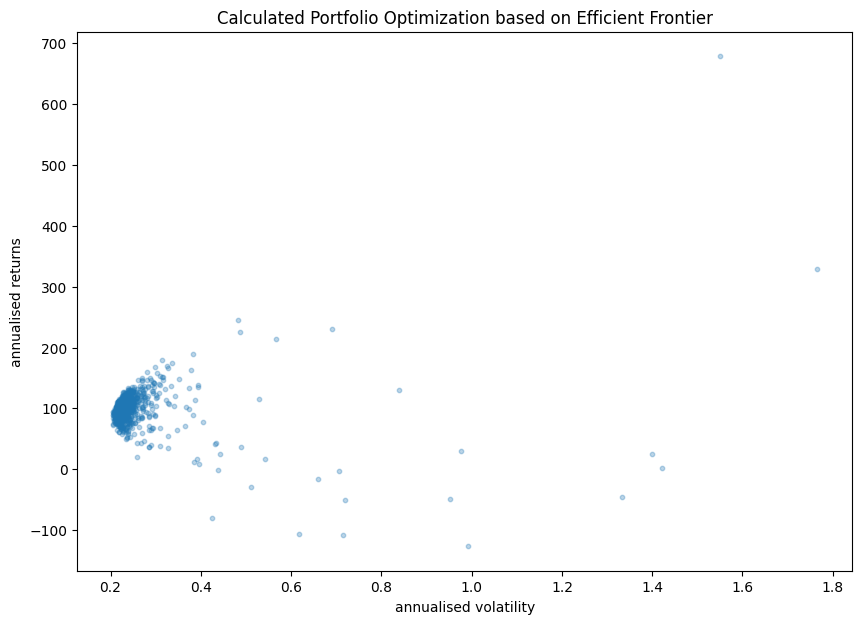

In [28]:
mean_frontier = aml.MC_ef_frontier(ret, covmat, itertimes = 100, random_seed = 42)

#### Exercise 4
Exercise 2를 반복한다. 여기서 이번에는 100개의 Efficient Frontier를 계산하기 전에 공분산 행렬에서 Lehmann Wolf Reduction을 적용한다. 오차의 분산이 유의하게 더 높은가 아니면 더 낮은가? 그 이유는 무엇인가?

In [30]:
ret

,KODEX,KOSPI200,KOSDAQ150,Samsung,LG,Posco
Date,,,,,,
2019-01-23,0.005788,0.004982,-0.004474,-0.003565,0.010794,-0.007519
2019-01-24,0.008205,0.008511,0.014955,0.024693,0.000000,-0.001889
2019-01-25,0.017996,0.018435,0.011246,0.038729,0.063867,0.013146
2019-01-28,-0.000582,-0.000310,0.007832,0.006682,-0.026241,0.003724
2019-01-29,0.004838,0.005020,-0.001735,0.009939,-0.004441,-0.001860
...,...,...,...,...,...,...
2023-06-09,0.013188,0.013186,0.014153,0.015396,-0.003954,0.015346
2023-06-12,-0.006485,-0.006789,0.003691,-0.013986,-0.004766,-0.006365
2023-06-13,0.004752,0.005204,0.019701,0.013986,-0.009600,-0.005122


In [41]:
nBlocks, bSize, bCorr = 2, 2, .5
np.random.seed(0)
mu0, cov0 = aml.formTrueMatrix(nBlocks, bSize, bCorr)
nObs, nTrials, bWidth, shrink, minVarPortf = 1085, 5, .01, False, True
w1 = pd.DataFrame(columns = range(cov0.shape[0]), index = range(nTrials), dtype=float)

In [42]:
w1_d = w1.copy(deep=True)
for i in range(nTrials):
    mu1, cov1 = aml.simCovMu(mu0, cov0, nObs, shrink = True)
    if minVarPortf: mu1 = None
    cov1_d = aml.deNoiseCov(cov1, nObs*1./cov1.shape[1], bWidth)
    w1.loc[i] = aml.optPort(cov1, mu1).flatten() # add column vector w as row in w1
    w1_d.loc[i] = aml.optPort(cov1_d, mu1).flatten() # np.sum(w1_d, axis=1) is vector of 1's. sum(np.sum(w1_d, axis=0)= nTrials
    # so minimum-variance-portfolio is 1./nTrials*(np.sum(w1_d, axis=0)) - but distribution not stationary

min_var_port = 1./nTrials * (np.sum(w1_d, axis = 0))

found errPDFs0.99999
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Aug 30 01:11:53 AM: Your problem has 4 variables, 2 constraints, and 0 parameters.
(CVXPY) Aug 30 01:11:53 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 30 01:11:53 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 30 01:11:53 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 30 01:11:53 AM: Compiling problem (target solver=OSQP).
(CVXPY) Aug 30 01:11:53 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp

In [43]:
min_var_port

0    0.19882
1    0.25962
2    0.39734
3    0.14422
dtype: float64